- [Feature Engineering_2](#feature-engineering-2)
- [Feature Engineering_3](#feature-engineering-3)
- [Feature Engineering_4](#feature-engineering-4)

# Feature Engineering 2

## Mean Encoding
- Category 데이터는 항상 One-hot Encoding만 해야하는 것은 아님.
- 다양한 인코딩 기법이 있음.
- 대표적인 방법으로 Y값에 대한 분포를 활용한 Mean Encoding이 사용됨.
- Label Encoding은 그 자체로 정보가 존재하지 않지만, Mean encoding은 분포의 값을 취할 수 있음.
- 조금 더 빨리, 조금 더 나은 성능이 나오기도 함.
- Regression Task(예측 문제)는 단순 평균값으로 입력함.
- Overfitting을 제거하기 위해 smoothing을 사용함.

- [Data_Preprocessing_4](https://github.com/yongchoooon/TIL/blob/main/ML/Data_Preprocessing/Data_Preprocessing_4.ipynb)의 titanic data 불러오기

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set(style="white") # white background style for seaborn plots
sns.set(style="whitegrid", color_codes = True)

In [2]:
DATA_DIR = './titanic'
data_files = reversed([os.path.join(DATA_DIR, filename) for filename in os.listdir(DATA_DIR)])
df_list = []
for filename in data_files:
    df_list.append(pd.read_csv(filename))

df = pd.concat(df_list, sort=False) 
df = df.reset_index(drop=True) 

number_of_train_dataset = df.Survived.notnull().sum() 
number_of_test_dataset = df.Survived.isnull().sum() 
y_true = df.pop("Survived")[:number_of_train_dataset] 

df["Age"] = df["Age"].fillna(
    df.groupby(["Pclass"])["Age"].transform("mean")
)

object_columns = ["PassengerId", "Pclass", "Name", "Sex", "Ticket", "Cabin", "Embarked"]
numeric_columns = ["Age", "SibSp", "Parch", "Fare"]

# 데이터 타입 변경
for col_name in object_columns:
    df[col_name] = df[col_name].astype(object)

for col_name in numeric_columns:
    df[col_name] = df[col_name].astype(float)
    
df["Parch"] = df["Parch"].astype(int)
df["SibSp"] = df["SibSp"].astype(int)

df.loc[61, "Embarked"] = "S"
df.loc[829, "Embarked"] = "S"

# df 2개를 inner로 merge해주는 함수
def merge_and_get(ldf, rdf, on, how="inner", index = None):
    if index is True:
        return pd.merge(ldf, rdf, how = how, left_index = True, right_index = True)
    else:
        return pd.merge(ldf, rdf, how = how, on = on)

one_hot_df = merge_and_get(df, pd.get_dummies(df["Sex"], prefix = "Sex"), on = None, index = True) # sex_modified
one_hot_df = merge_and_get(one_hot_df, pd.get_dummies(df["Pclass"], prefix = "Pclass"), on = None, index = True)
one_hot_df = merge_and_get(one_hot_df, pd.get_dummies(df["Embarked"], prefix = "Embarked"), on = None, index = True)
one_hot_df.head(2)

c:\Miniconda3\envs\da\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,1,0,0,1,0,0


- Mean Encoding

In [3]:
temp_df = pd.merge(
    one_hot_df["Pclass"], y_true, left_index = True, right_index = True)
temp_df.groupby("Pclass")["Survived"].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

In [4]:
temp_df["Pclass"].replace(
    temp_df.groupby("Pclass")["Survived"].mean())

0      0.242363
1      0.629630
2      0.242363
3      0.629630
4      0.242363
         ...   
886    0.472826
887    0.629630
888    0.242363
889    0.629630
890    0.242363
Name: Pclass, Length: 891, dtype: float64

In [5]:
temp_columns = ["Sex", "Pclass", "Embarked"]

me_list = []
for col_name in temp_columns:
    temp_df = pd.merge(one_hot_df[col_name], y_true, left_index = True, right_index = True)
    temp_df["me_"+col_name] = temp_df[col_name].replace(temp_df.groupby(col_name)["Survived"].mean())
    me_list.append(temp_df.drop("Survived", axis = 1))
    # sns.countplot(x = col_name, hue = "Survived", data = temp_df)
    # plt.show()
    # sns.countplot(x = "me_" + col_name, hue = "Survived", data = temp_df)
    # plt.show()
me_list[2]


,Embarked,me_Embarked
0,S,0.339009
1,C,0.553571
2,S,0.339009
3,S,0.339009
4,S,0.339009
...,...,...
886,S,0.339009
887,S,0.339009
888,S,0.339009
889,C,0.553571


- Mean Encoding을 하면 Suvived와의 상관계수가 0.54, 0.34, 0.17로, 하지 않았을 때에 비해 높아졌다.
- 따라서 Mean Encoding을 하면 데이터를 더 잘 설명할 수 있다.

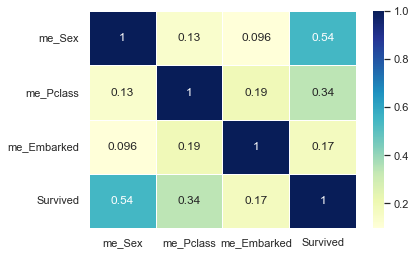

In [6]:
temp_df = pd.merge(
    pd.concat(me_list, axis = 1)[["me_" + col_name for col_name in temp_columns]],
    y_true, left_index = True, right_index = True)
# temp_df

corr = temp_df.corr()
sns.set()
ax = sns.heatmap(corr, annot = True, linewidths = 0.5, cmap = "YlGnBu")

- 이외에도 많은 Encoding 기법들이 존재함

## Interaction feature
- 기존 feature들의 조합으로 새로운 feature를 생성
- Data에 대한 사전 지식과 이해가 필요
- Polynomial feature를 사용한 자동화 가능 
    - `sklearn.preprocessing.PolynomialFeatures`
    - 높은 비용
- 실험적으로 접근할 요소들은 있음
    - 자동화 코드 만들면 됨.
- ex) weight, time-period, sensor1 + sensor2

- Categorical Combination
    - Sex와 Pclass, Embarked와 Pclass를 combination

In [7]:
temp_columns = ["Sex", "Pclass", "Embarked"]
one_hot_df["Sex-Pclass"] = df["Sex"].map(str) + df["Pclass"].map(str)
one_hot_df["Embarked-Pclass"] = df["Embarked"].map(str) + df["Pclass"].map(str)
one_hot_df = merge_and_get(one_hot_df, pd.get_dummies(one_hot_df["Sex-Pclass"], prefix = "SexPclass"), on = None, index = True)
one_hot_df = merge_and_get(one_hot_df, pd.get_dummies(one_hot_df["Embarked-Pclass"], prefix = "EmbarkedPclass"), on = None, index = True)
one_hot_df.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SexPclass_male3,EmbarkedPclass_C1,EmbarkedPclass_C2,EmbarkedPclass_C3,EmbarkedPclass_Q1,EmbarkedPclass_Q2,EmbarkedPclass_Q3,EmbarkedPclass_S1,EmbarkedPclass_S2,EmbarkedPclass_S3
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,...,1,0,0,0,0,0,0,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,...,0,1,0,0,0,0,0,0,0,0


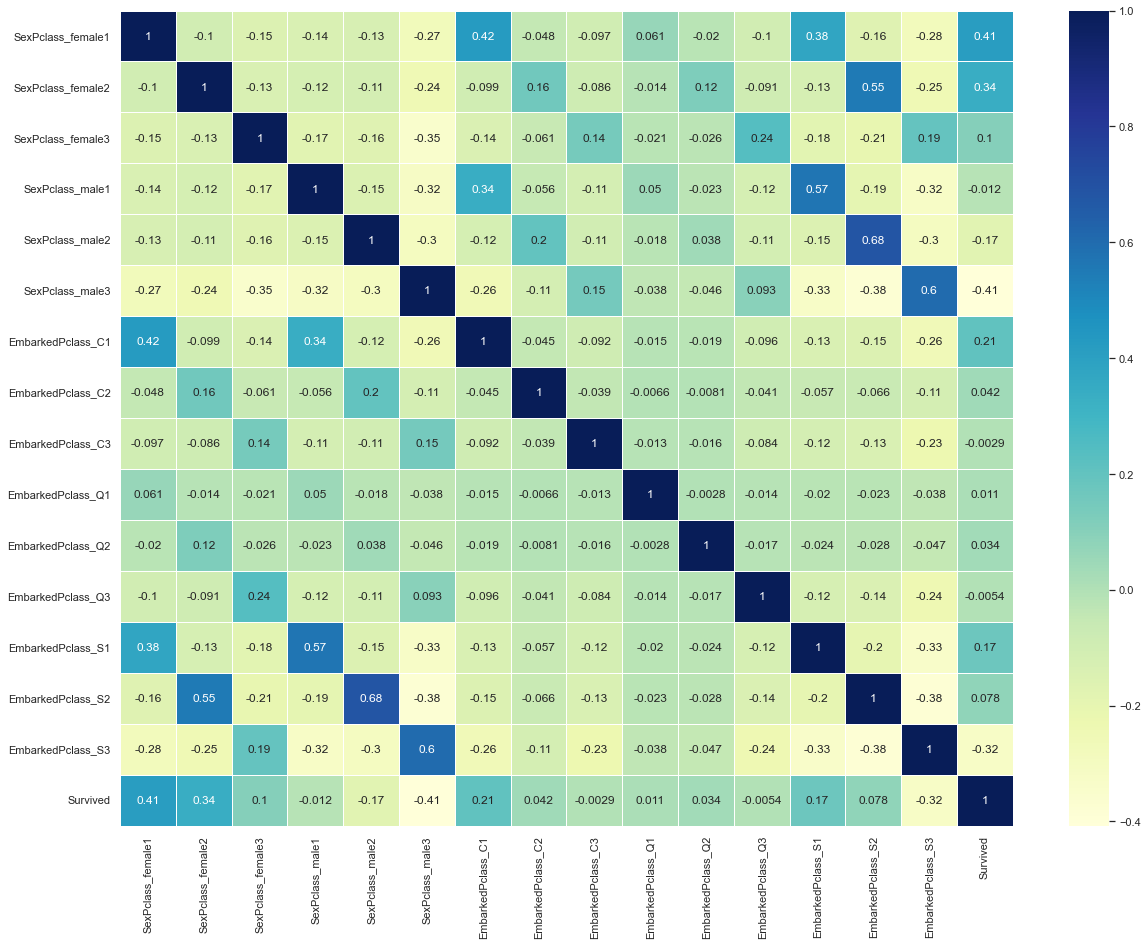

In [8]:
crosscheck_columns = [col_name for col_name in one_hot_df.columns.tolist()
                      if col_name.split("_")[0] in ["SexPclass", "EmbarkedPclass"] and "_" in col_name]
temp_df = pd.merge(one_hot_df[crosscheck_columns], y_true, left_index = True, right_index = True)

corr = temp_df.corr()
plt.subplots(figsize = (20, 15))
ax = sns.heatmap(corr, annot = True, linewidths = 0.5, cmap = "YlGnBu")

- 맨 아랫줄만 보면, 성별이 여자이고 Pclass가 1이면 상관계수가 0.41로 살 확률이 높고, 성별이 여자인데도 Pclass가 3이면 상관계수가 0.1로 살 확률이 적다.
- Embarked가 동일하게 C라 하더라고 Pclass가 1일 때 0.21로 살 확률이 높고, Pclass가 3이면 -0.0029로, 죽을 확률이 적게 존재한다. 

## Etc
- Feature끼리 더하기, 곱하기, 나누기 등등
- 왜 잘 되는지 모르는데 잘 되는 경우가 있음
- 도메인 지식과 EDA로 좋은 Feature들을 생성

---

# Feature Engineering 3

## Numeric data types

- 전체 numeric type column에 대해 pairplot 확인

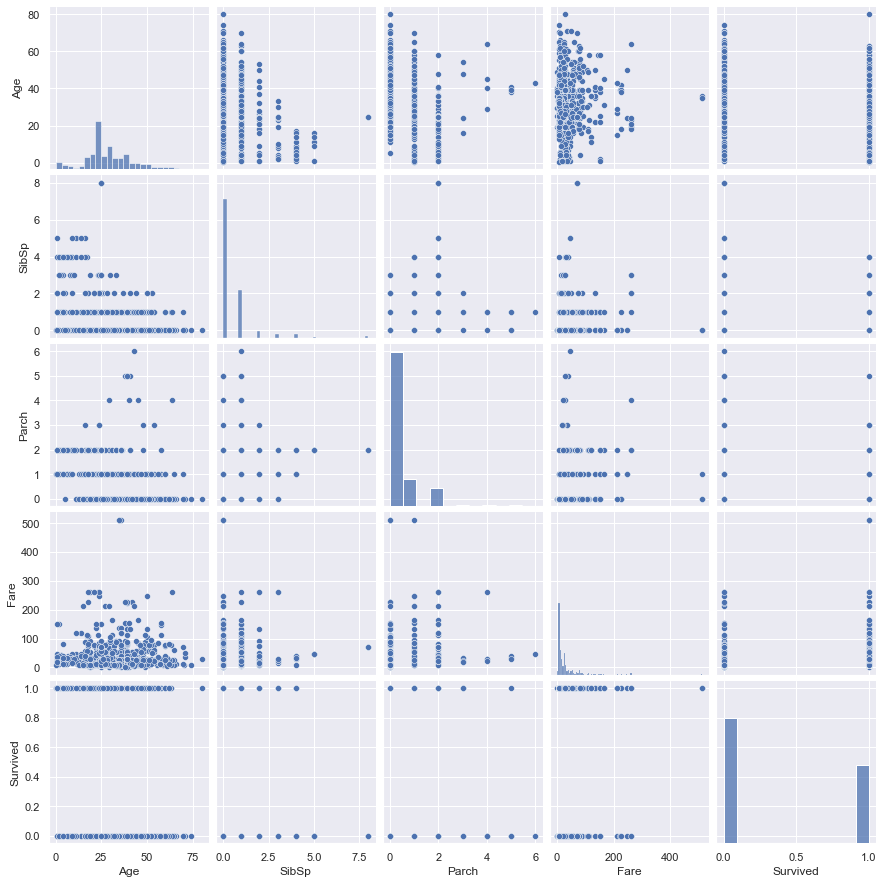

In [9]:
temp_df = pd.merge(one_hot_df[numeric_columns], y_true, left_index = True, right_index = True)

sns.pairplot(temp_df)

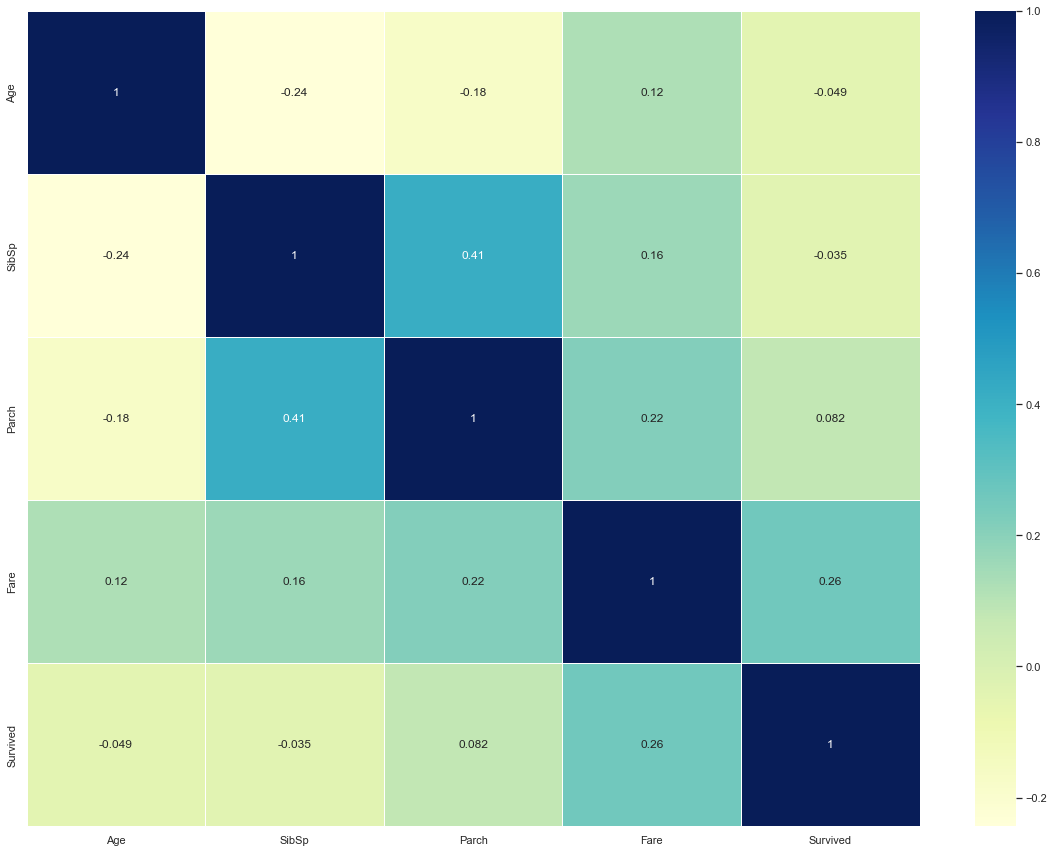

In [10]:
corr = temp_df.corr()
sns.set()
plt.subplots(figsize=(20,15))
ax = sns.heatmap(corr, annot = True, linewidths = 0.8, cmap = "YlGnBu")

- 이렇게 numeric type column끼리 그래프를 그려서 확인해보면서 데이터가 어떤지 확인해보는 것이 중요함.
- 아래 그래프에서는 형제자매가 많을수록 운임료가 높아지고, 형제자매가 매우 많아지면 다 죽었다는 것을 알 수 있음.

<AxesSubplot:xlabel='SibSp', ylabel='Fare'>

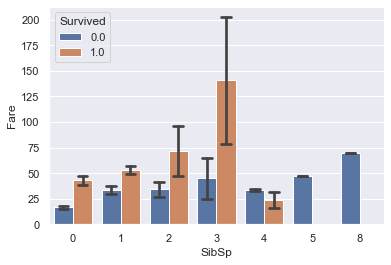

In [11]:
sns.barplot(x = "SibSp", y = "Fare", hue = "Survived", data = temp_df, ci = 68, capsize = 0.2)

<AxesSubplot:xlabel='Parch', ylabel='Fare'>

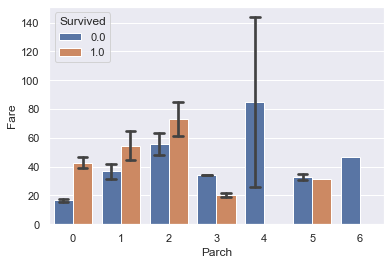

In [12]:
sns.barplot(x = "Parch", y = "Fare", hue = "Survived", data = temp_df, ci = 68, capsize = 0.2)

<AxesSubplot:xlabel='SibSp', ylabel='Age'>

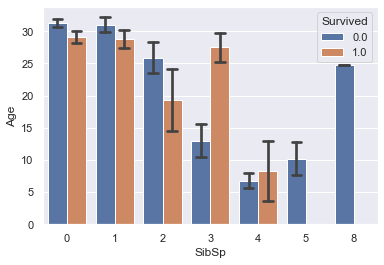

In [13]:
sns.barplot(x = "SibSp", y = "Age", hue = "Survived", data = temp_df, ci = 68, capsize = 0.2)

<AxesSubplot:xlabel='Parch', ylabel='Fare'>

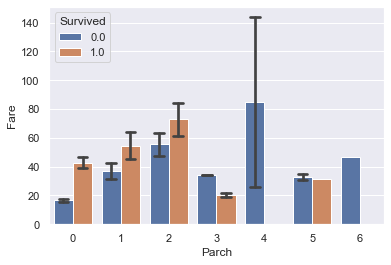

In [14]:
sns.barplot(x = "Parch", y = "Fare", hue = "Survived", data = temp_df, ci = 68, capsize = 0.2)

## Binning

In [15]:
one_hot_df["Fare"].value_counts()

8.0500     60
13.0000    59
7.7500     55
26.0000    50
7.8958     49
           ..
7.7417      1
8.1583      1
8.4583      1
7.8000      1
7.7208      1
Name: Fare, Length: 281, dtype: int64

<AxesSubplot:>

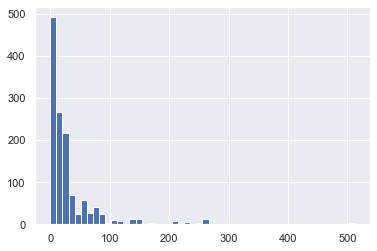

In [16]:
one_hot_df["Fare"].hist(bins = 50)

- 이건 되게 극단적인 long tail 데이터이기 때문에 Log Transform 과정이 필요해보인다.

In [17]:
# warning 무시
import warnings
warnings.filterwarnings(action='ignore')

## Log Transform

- 지금 4개의 numeric type column들은 long tail 데이터이기 때문에 Log Transform 과정을 거쳐야 함

In [18]:
# copy
bin_one_hot_df = one_hot_df.copy()

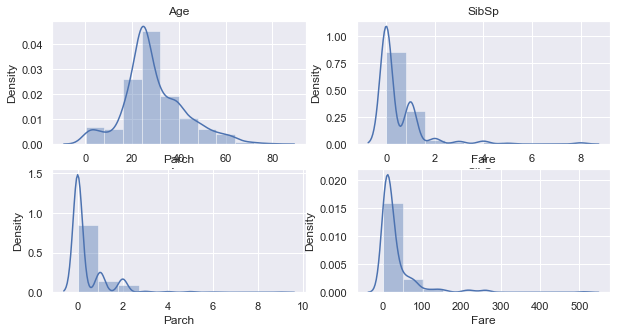

In [19]:
fig = plt.figure()
fig.set_size_inches(10, 5)

ax = []
for i, col_name in enumerate(numeric_columns):
    ax.append(fig.add_subplot(2, 2, i+1))
    X_1 = bin_one_hot_df[col_name]

    ax[i] = sns.distplot(X_1, bins = 10)
    ax[i].set_title(col_name)

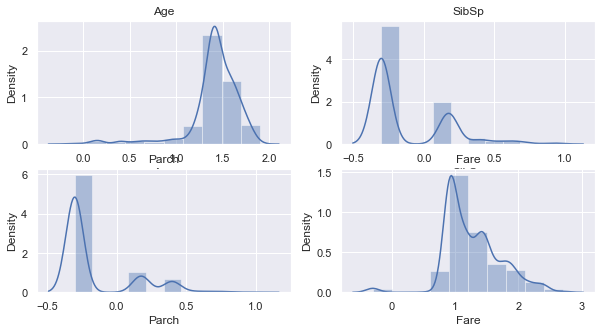

In [20]:
fig = plt.figure()
fig.set_size_inches(10, 5)

ax = []
for i, col_name in enumerate(numeric_columns):
    ax.append(fig.add_subplot(2, 2, i+1))
    X_1 = np.log10(bin_one_hot_df[col_name] + 0.5)

    ax[i] = sns.distplot(X_1, bins = 10)
    ax[i].set_title(col_name)

- 이렇게 Log Transformation을 하니까 "Fare"는 정규분포의 형태로 잘 된 것 같다. 그래서 "Fare"는 이 값을 그대로 입력해서 보자.

In [21]:
bin_one_hot_df.isnull().sum()

PassengerId             0
Pclass                  0
Name                    0
Sex                     0
Age                     0
SibSp                   0
Parch                   0
Ticket                  0
Fare                    1
Cabin                1014
Embarked                0
Sex_female              0
Sex_male                0
Pclass_1                0
Pclass_2                0
Pclass_3                0
Embarked_C              0
Embarked_Q              0
Embarked_S              0
Sex-Pclass              0
Embarked-Pclass         0
SexPclass_female1       0
SexPclass_female2       0
SexPclass_female3       0
SexPclass_male1         0
SexPclass_male2         0
SexPclass_male3         0
EmbarkedPclass_C1       0
EmbarkedPclass_C2       0
EmbarkedPclass_C3       0
EmbarkedPclass_Q1       0
EmbarkedPclass_Q2       0
EmbarkedPclass_Q3       0
EmbarkedPclass_S1       0
EmbarkedPclass_S2       0
EmbarkedPclass_S3       0
dtype: int64

- Fare 빈 칸 하나는 평균으로 채우기

In [22]:
bin_one_hot_df["Fare"] = bin_one_hot_df["Fare"].fillna(bin_one_hot_df["Fare"].mean())

- Fare값은 Log Transformation 해서 column 추가

In [23]:
log_bin_one_hot_df = merge_and_get(bin_one_hot_df, np.log10(bin_one_hot_df["Fare"] + 0.5), on = None, index = True)
log_bin_one_hot_df.rename(columns = {'Fare_x' : 'Fare',
                                     'Fare_y' : 'log_fare'},
                                     inplace = True)
log_bin_one_hot_df.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,EmbarkedPclass_C1,EmbarkedPclass_C2,EmbarkedPclass_C3,EmbarkedPclass_Q1,EmbarkedPclass_Q2,EmbarkedPclass_Q3,EmbarkedPclass_S1,EmbarkedPclass_S2,EmbarkedPclass_S3,log_fare
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,...,0,0,0,0,0,0,0,0,1,0.889302
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,...,1,0,0,0,0,0,0,0,0,1.856023


In [24]:
object_columns

['PassengerId', 'Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

- numeric 데이터에 대한 시각화 
    - 아래와 같이 어떤 그래프든, 어떤 방식으로든 시각화를 해 보면서 데이터가 어떤지 봐야 함

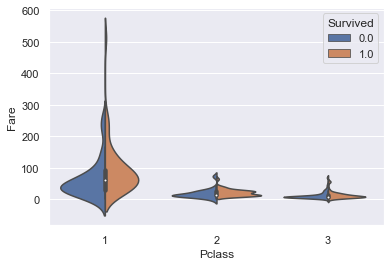

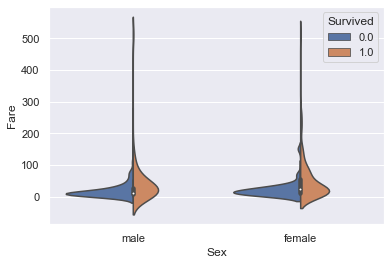

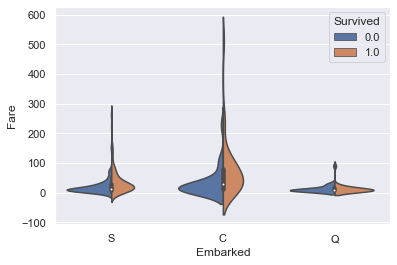

In [25]:
temp_df = pd.merge(log_bin_one_hot_df[numeric_columns + object_columns], y_true, left_index = True, right_index = True)

for col_name in ["Pclass", "Sex", "Embarked"]:
    sns.violinplot(x = col_name, y = "Fare", hue = "Survived", data = temp_df, split = True)
    plt.show()

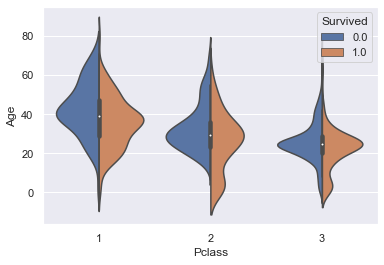

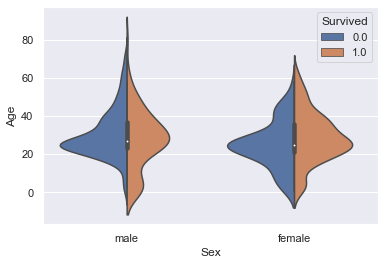

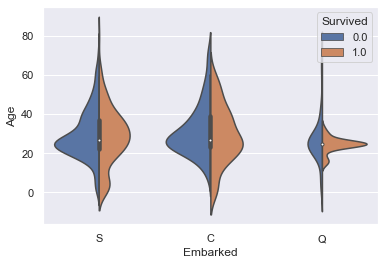

In [26]:
temp_df = pd.merge(log_bin_one_hot_df[numeric_columns + object_columns], y_true, left_index = True, right_index = True)

for col_name in ["Pclass", "Sex", "Embarked"]:
    sns.violinplot(x = col_name, y = "Age", hue = "Survived", data = temp_df, split = True)
    plt.show()

- 나이는 웬만하면 다 정규분포를 따르고 있구나.
- Embarked Q의 경우에는 왜 나이가 비슷한 사람들이 많이 탔지? 라는 생각을 할 수 있음.

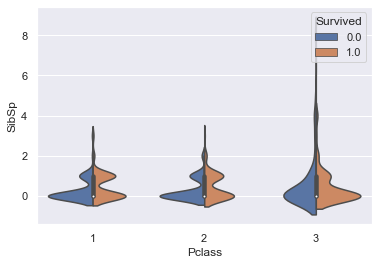

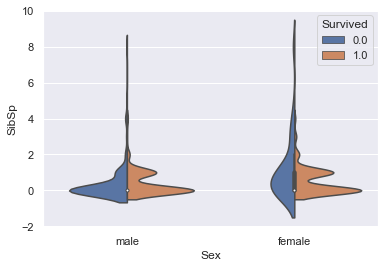

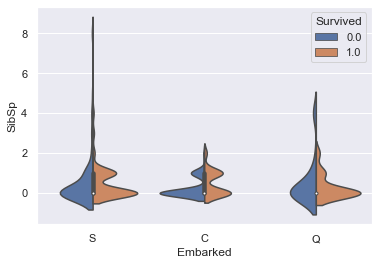

In [27]:
temp_df = pd.merge(log_bin_one_hot_df[numeric_columns + object_columns], y_true, left_index = True, right_index = True)

for col_name in ["Pclass", "Sex", "Embarked"]:
    sns.violinplot(x = col_name, y = "SibSp", hue = "Survived", data = temp_df, split = True)
    plt.show()

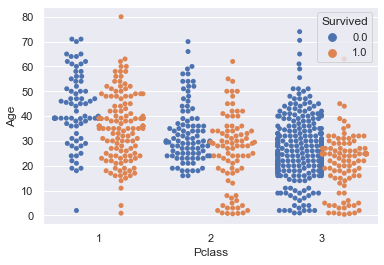

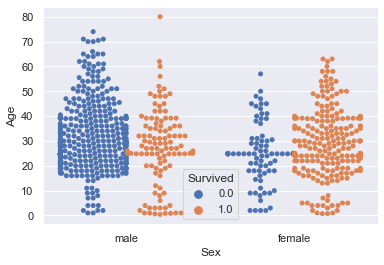

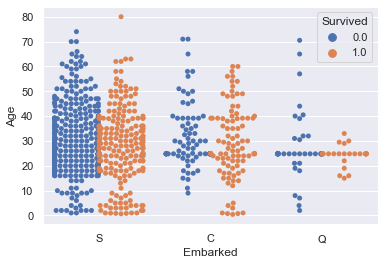

In [28]:
temp_df = pd.merge(log_bin_one_hot_df[numeric_columns + object_columns], y_true, left_index = True, right_index = True)

for col_name in ["Pclass", "Sex", "Embarked"]:
    sns.swarmplot(x = col_name, y = "Age", hue = "Survived", data = temp_df, split = True)
    plt.show()

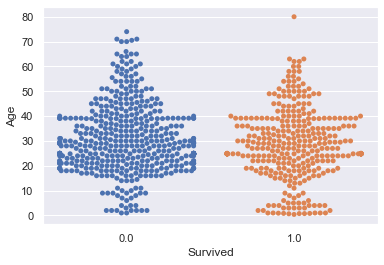

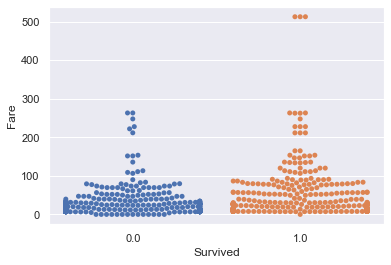

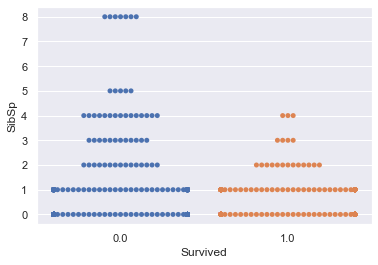

In [29]:
temp_df = pd.merge(log_bin_one_hot_df[numeric_columns + object_columns], y_true, left_index = True, right_index = True)

for col_name in ["Age", "Fare", "SibSp"]:
    sns.swarmplot(x = "Survived", y = col_name, data = temp_df, split = True)
    plt.show()

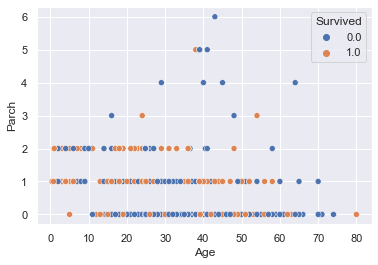

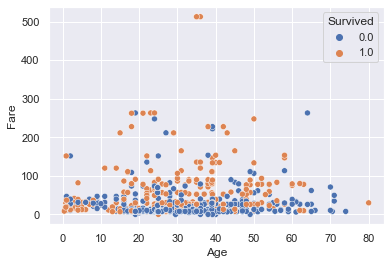

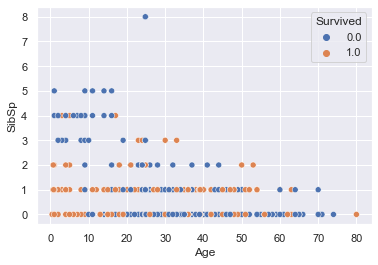

In [30]:
temp_df = pd.merge(log_bin_one_hot_df[numeric_columns + object_columns], y_true, left_index = True, right_index = True)

for col_name in ["Parch", "Fare", "SibSp"]:
    sns.scatterplot(x = "Age", y = col_name, data = temp_df, hue = "Survived")
    plt.show()

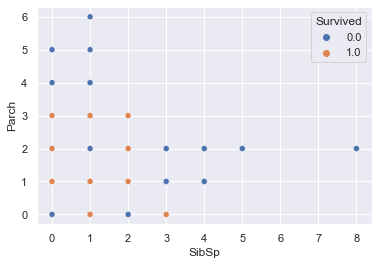

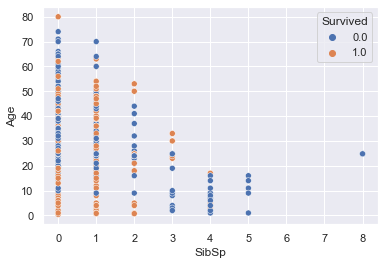

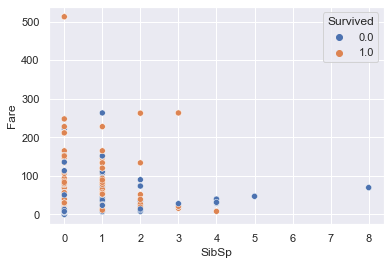

In [31]:
temp_df = pd.merge(log_bin_one_hot_df[numeric_columns + object_columns], y_true, left_index = True, right_index = True)

for col_name in ["Parch", "Age", "Fare"]:
    sns.scatterplot(x = "SibSp", y = col_name, data = temp_df, hue = "Survived")
    plt.show()

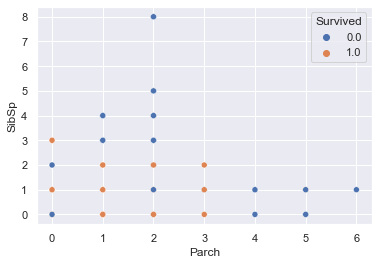

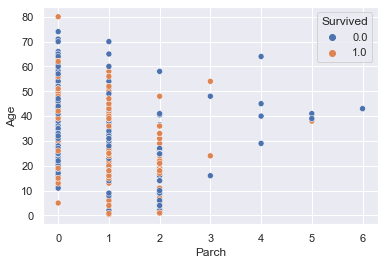

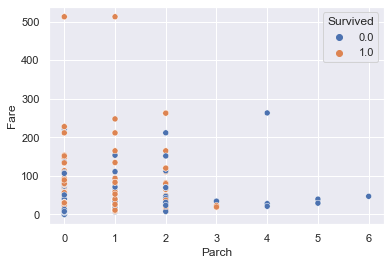

In [32]:
temp_df = pd.merge(log_bin_one_hot_df[numeric_columns + object_columns], y_true, left_index = True, right_index = True)

for col_name in ["SibSp", "Age", "Fare"]:
    sns.scatterplot(x = "Parch", y = col_name, data = temp_df, hue = "Survived")
    plt.show()

- 아래는 `PolynomialFeatures`를 활용해서 numeric columns를 combination을 시켜주고 corr를 확인해본 heatmap인데,
- 이 heatmap은 수가 너무 많아서 사실 어떤 feature에 주목해야할 지 보기 어렵다.
- 하지만 Survived에 대한 corr가 색이 진한 것이 있으면 영향을 좀 크게 주는 것으로 생각할 수 있다.
- 이들은 이후에 더 분석해봐야 할 것이다.

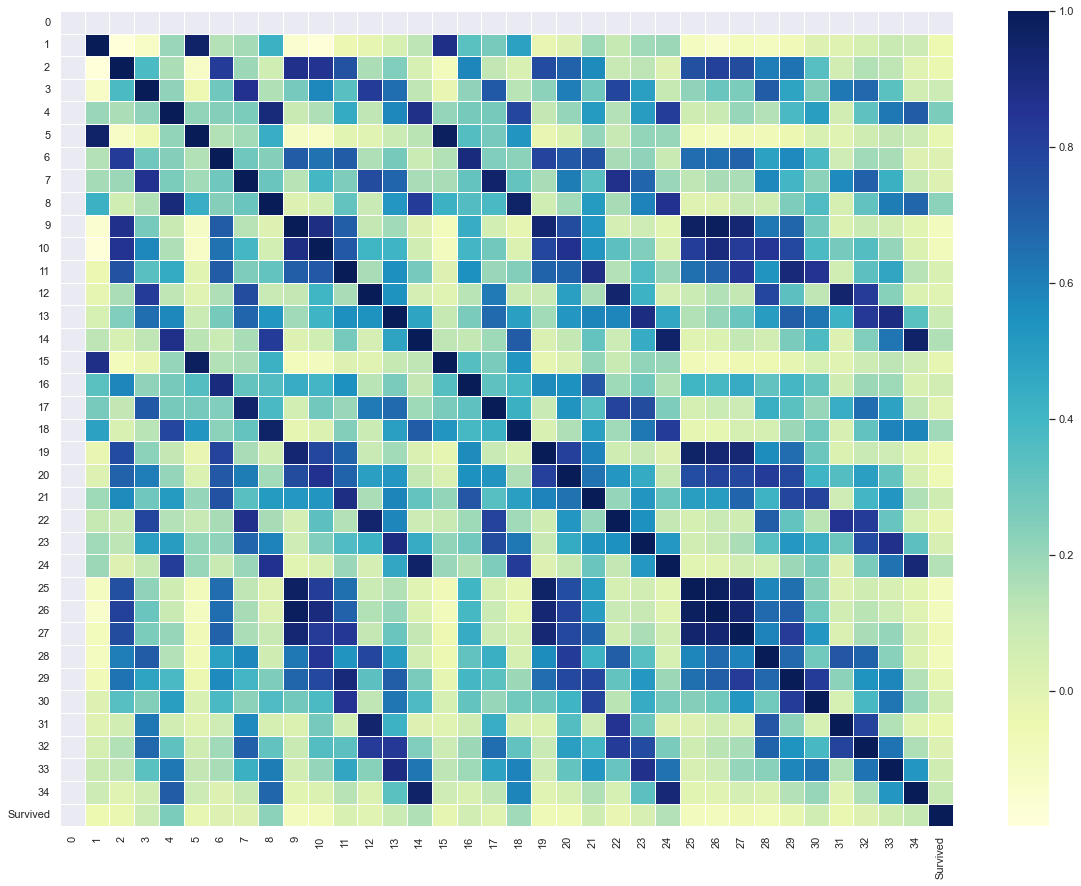

In [33]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree = 3)
X_poly = pd.DataFrame(
    poly_features.fit_transform(log_bin_one_hot_df[numeric_columns]))

temp_df = pd.concat([X_poly, y_true], axis = 1)
corr = temp_df.corr()
sns.set()
plt.subplots(figsize = (20, 15))
ax = sns.heatmap(corr, linewidths = 0.8, cmap = "YlGnBu")

## String Handling

In [34]:
from collections import Counter
Counter((log_bin_one_hot_df["Name"].str.lower() + " ").sum().split()).most_common(3)

[('mr.', 757), ('miss.', 260), ('mrs.', 197)]

In [35]:
log_bin_one_hot_df["is_mr"] = log_bin_one_hot_df["Name"].str.lower().str.contains(pat = 'mr.')
log_bin_one_hot_df["is_miss"] = log_bin_one_hot_df["Name"].str.lower().str.contains(pat = 'miss.')
log_bin_one_hot_df["is_mrs"] = log_bin_one_hot_df["Name"].str.lower().str.contains(pat = 'mrs.')

In [36]:
log_bin_one_hot_df["Ticket"]

0                A/5 21171
1                 PC 17599
2         STON/O2. 3101282
3                   113803
4                   373450
               ...        
1304             A.5. 3236
1305              PC 17758
1306    SOTON/O.Q. 3101262
1307                359309
1308                  2668
Name: Ticket, Length: 1309, dtype: object

In [37]:
log_bin_one_hot_df["Ticket"].str.rsplit(expand = True, )

,0,1,2
0,A/5,21171,None
1,PC,17599,None
2,STON/O2.,3101282,None
3,113803,None,None
4,373450,None,None
...,...,...,...
1304,A.5.,3236,None
1305,PC,17758,None
1306,SOTON/O.Q.,3101262,None
1307,359309,None,None


In [38]:
log_bin_one_hot_df["Ticket"].str.extractall('(\d+)')

0
     match         
0    0            5
     1        21171
1    0        17599
2    0            2
     1      3101282
...             ...
1304 1         3236
1305 0        17758
1306 0      3101262
1307 0       359309
1308 0         2668

[1373 rows x 1 columns]

In [39]:
Counter((log_bin_one_hot_df["Ticket"].str.lower() + " ").sum().split()).most_common(30)

[('pc', 92),
 ('c.a.', 46),
 ('sc/paris', 16),
 ('soton/o.q.', 16),
 ('2.', 15),
 ('w./c.', 14),
 ('ston/o', 14),
 ('a/5', 12),
 ('ca.', 12),
 ('2343', 11),
 ('a/5.', 10),
 ('ca', 10),
 ('f.c.c.', 9),
 ('2144', 8),
 ('1601', 8),
 ('soton/oq', 8),
 ('c', 8),
 ('ston/o2.', 7),
 ('347082', 7),
 ('347077', 7),
 ('3101295', 7),
 ('s.o.c.', 7),
 ('14879', 7),
 ('17608', 7),
 ('s.o./p.p.', 7),
 ('382652', 6),
 ('19950', 6),
 ('347088', 6),
 ('113781', 6),
 ('a/4', 6)]

In [40]:
log_bin_one_hot_df["is_pc"] = log_bin_one_hot_df["Ticket"].str.lower().str.contains(pat = 'pc')
log_bin_one_hot_df["is_ca"] = log_bin_one_hot_df["Ticket"].str.lower().str.contains(pat = 'c.a.')
log_bin_one_hot_df["is_paris"] = log_bin_one_hot_df["Ticket"].str.lower().str.contains(pat = 'paris')
log_bin_one_hot_df["is_soton"] = log_bin_one_hot_df["Ticket"].str.lower().str.contains(pat = 'soton')
log_bin_one_hot_df["is_ston"] = log_bin_one_hot_df["Ticket"].str.lower().str.contains(pat = 'ston')
log_bin_one_hot_df["is_so"] = log_bin_one_hot_df["Ticket"].str.lower().str.contains(pat = 's.o')

In [41]:
log_bin_one_hot_df.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,log_fare,is_mr,is_miss,is_mrs,is_pc,is_ca,is_paris,is_soton,is_ston,is_so
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,...,0.889302,True,False,False,False,False,False,False,False,False
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,...,1.856023,True,False,True,True,False,False,False,False,False


In [42]:
log_bin_one_hot_df.isnull().sum()

PassengerId             0
Pclass                  0
Name                    0
Sex                     0
Age                     0
SibSp                   0
Parch                   0
Ticket                  0
Fare                    0
Cabin                1014
Embarked                0
Sex_female              0
Sex_male                0
Pclass_1                0
Pclass_2                0
Pclass_3                0
Embarked_C              0
Embarked_Q              0
Embarked_S              0
Sex-Pclass              0
Embarked-Pclass         0
SexPclass_female1       0
SexPclass_female2       0
SexPclass_female3       0
SexPclass_male1         0
SexPclass_male2         0
SexPclass_male3         0
EmbarkedPclass_C1       0
EmbarkedPclass_C2       0
EmbarkedPclass_C3       0
EmbarkedPclass_Q1       0
EmbarkedPclass_Q2       0
EmbarkedPclass_Q3       0
EmbarkedPclass_S1       0
EmbarkedPclass_S2       0
EmbarkedPclass_S3       0
log_fare                0
is_mr                   0
is_miss     

In [43]:
test = log_bin_one_hot_df["Cabin"].fillna("99999")
Counter((test.str.lower() + " ").sum().split()).most_common(30)

[('99999', 1014),
 ('f', 8),
 ('c23', 6),
 ('c25', 6),
 ('c27', 6),
 ('g6', 5),
 ('b57', 5),
 ('b59', 5),
 ('b63', 5),
 ('b66', 5),
 ('f33', 4),
 ('f2', 4),
 ('f4', 4),
 ('c78', 4),
 ('d', 4),
 ('c22', 4),
 ('c26', 4),
 ('b96', 4),
 ('b98', 4),
 ('e46', 3),
 ('b58', 3),
 ('b60', 3),
 ('e101', 3),
 ('e34', 3),
 ('a34', 3),
 ('c101', 3),
 ('b51', 3),
 ('b53', 3),
 ('b55', 3),
 ('c85', 2)]

In [44]:
log_bin_one_hot_df["is_cabin_none"] = test.str.contains(pat = '99999')
log_bin_one_hot_df["is_cabin_a"] = test.str.contains(pat = 'a')
log_bin_one_hot_df["is_cabin_b"] = test.str.contains(pat = 'b')
log_bin_one_hot_df["is_cabin_c"] = test.str.contains(pat = 'c')
log_bin_one_hot_df["is_cabin_d"] = test.str.contains(pat = 'd')
log_bin_one_hot_df["is_cabin_e"] = test.str.contains(pat = 'e')
log_bin_one_hot_df["is_cabin_f"] = test.str.contains(pat = 'f')
log_bin_one_hot_df["is_cabin_g"] = test.str.contains(pat = 'g')

In [45]:
log_bin_one_hot_df.head(2).T

,0,1
PassengerId,1,2
Pclass,3,1
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th..."
Sex,male,female
Age,22.0,38.0
SibSp,1,1
Parch,0,0
Ticket,A/5 21171,PC 17599
Fare,7.25,71.2833
Cabin,NaN,C85


- 사실 분석을 할 때 이렇게 feature의 수가 많아지면 성능이 떨어지지만, 일단은 데이터를 확인해보기 위해 feature를 늘리는 작업이 필요함.

In [46]:
def count_cabin(x):
    if type(x) is int:
        return 0
    else:
        return len(x)

log_bin_one_hot_df["number_of_Cabin"] = log_bin_one_hot_df["Cabin"].str.split(" ").fillna(0).map(count_cabin)
log_bin_one_hot_df["log_number_of_Cabin"] = np.log(log_bin_one_hot_df["number_of_Cabin"] + 0.01)

<AxesSubplot:xlabel='number_of_Cabin', ylabel='count'>

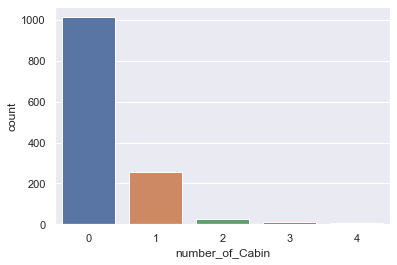

In [47]:
sns.countplot(log_bin_one_hot_df["number_of_Cabin"])

- Cabin이 없는 경우가 제일 많고, Cabin의 길이가 1, 2, 3, 4인 경우로 이렇게 있구나. 라는 정보 확인

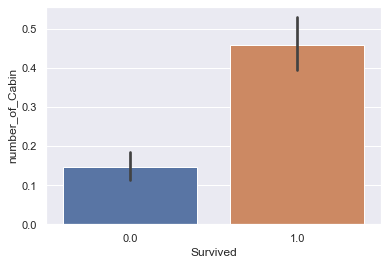

                     number_of_Cabin  log_number_of_Cabin  Survived
number_of_Cabin             1.000000             0.924291  0.277053
log_number_of_Cabin         0.924291             1.000000  0.314632
Survived                    0.277053             0.314632  1.000000


In [48]:
temp_df = pd.merge(log_bin_one_hot_df[["number_of_Cabin", "log_number_of_Cabin"]], y_true, left_index = True, right_index = True)
sns.barplot(x = "Survived", y = "number_of_Cabin", data = temp_df)
plt.show()
print(temp_df.corr())

- 이렇게 보면 Cabin과 Survived 간에는 어느 정도 관계가 있구나. 하는 걸 알 수 있음.

---

# Feature Engineering 4

## Feature Selection
- 가장 적합한 특성을 선택하는 방법
- 모든 feature들이 반드시 model 학습에 필요하지 않음
- 어떤 feature들은 성능을 오히려 나쁘게 함
- 너무 많은 feature -> overfitting의 원인
- 모델에 따라서 필요한 feature를 선택함
- 필요없는 feature 제거 -> 학습 속도와 성능 향상
- 다양한 기법과 코드에 대해 공부

- feature 선택의 주의 사항들
    - prediction time에도 쓸 수 있는 feature인가?
    - 실시간 예측이 필요할 때, 생성이 너무 고비용이 아닌가?
    - scale은 일정한가? 또는 비율적으로 표현 가능한가?
    - 새롭게 등장하는 category data는? 가장 비슷한 것으로 해야하나?
    - 너무 극단적인 분포 -> threshold 기반으로 binarization

- 이런 Feature들은 삭제하자!
    - Correlation이 너무 높은 Feature는 삭제하자! (두 feature간의 상관계수를 의미함)
    - 전처리가 완료된 str feature들
    - ID와 같은 성향을 가진 feature들

## Model & Training

- 데이터의 정리가 끝나면 학습하는 방법
    - 적합한 모델을 선정한다 (실험적으로 정함)
    - 모델에 적합한 하이퍼 파라메터를 선정한다 (실험적으로 정함)
    - 다양한 전처리 경우의 수를 입력한다 (실험적으로 정함)
    - 학습을 실행한다
    - 성능을 평가한다 (성능 평가지표의 기준을 잡아야 함)


## Feature Elimination

In [62]:
features = log_bin_one_hot_df.columns.tolist()
print(features)

['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex-Pclass', 'Embarked-Pclass', 'SexPclass_female1', 'SexPclass_female2', 'SexPclass_female3', 'SexPclass_male1', 'SexPclass_male2', 'SexPclass_male3', 'EmbarkedPclass_C1', 'EmbarkedPclass_C2', 'EmbarkedPclass_C3', 'EmbarkedPclass_Q1', 'EmbarkedPclass_Q2', 'EmbarkedPclass_Q3', 'EmbarkedPclass_S1', 'EmbarkedPclass_S2', 'EmbarkedPclass_S3', 'log_fare', 'is_mr', 'is_miss', 'is_mrs', 'is_pc', 'is_ca', 'is_paris', 'is_soton', 'is_ston', 'is_so', 'is_cabin_none', 'is_cabin_a', 'is_cabin_b', 'is_cabin_c', 'is_cabin_d', 'is_cabin_e', 'is_cabin_f', 'is_cabin_g', 'number_of_Cabin', 'log_number_of_Cabin']


In [63]:
all_df = log_bin_one_hot_df.copy(deep = True)

elimination_features = ['PassengerId', 'Name', 'Cabin', 'Ticket']
for col_name in elimination_features:
    all_df.drop(col_name, axis = 1, inplace = True)

In [64]:
del all_df["Sex"]
del all_df["Pclass"]
del all_df["Embarked"]
del all_df["Sex-Pclass"]
del all_df["Embarked-Pclass"]

In [76]:
number_of_test_dataset

418

In [78]:
X_train = all_df[:number_of_train_dataset].values
X_test = all_df[number_of_train_dataset:].values
y_train = y_true.copy()

In [79]:
X_train.shape

(891, 47)

- RFE : Recursive Feature Elimination
    - 필요없는 feature들을 알아서 제거해 줌
- RandomForestClassifier : 모델

In [80]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

select = RFE(RandomForestClassifier(n_estimators = 100))

select.fit(X_train, y_train)

# transform training set
X_train_selected = select.transform(X_train)
X_train_selected.shape

(891, 23)

- 47개였던 feature가 23개로 줄어듦.

In [81]:
# 살아남은 features
all_df.columns[select.get_support()]

Index(['Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male', 'Pclass_1',
       'Pclass_3', 'Embarked_C', 'Embarked_S', 'SexPclass_female1',
       'SexPclass_female2', 'SexPclass_female3', 'SexPclass_male3',
       'EmbarkedPclass_S3', 'log_fare', 'is_mr', 'is_miss', 'is_mrs', 'is_so',
       'is_cabin_none', 'number_of_Cabin', 'log_number_of_Cabin'],
      dtype='object')

- Feature Elimination 전/후의 fit-predict

In [96]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators = 100, max_depth = 20, random_state = 0
)

# feature가 제거되기 전 X_train 값으로 fitting
clf.fit(X_train, y_train) 
# feature가 제거되기 전 X_test 값으로 prediction
idx = (all_df[number_of_train_dataset:].index+1).tolist()
y_pred = clf.predict((X_test))
y_pred

# feature가 제거된 후 X_train_selected 값으로 fitting
clf.fit(X_train_selected, y_train)
# feature가 제거된 후 X_test 값으로 prediction
idx = (all_df[number_of_train_dataset:].index+1).tolist()
y_pred_elim = clf.predict(select.transform(X_test))
y_pred_elim

array([0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 1., 1., 0.

- Kaggle에 제출

In [107]:
submission_columns = ["PassengerId", "Survived"]

# feature 제거 전
submission_df = pd.DataFrame([idx, y_pred]).T
submission_df.columns = submission_columns
for col_name in submission_columns:
    submission_df[col_name] = submission_df[col_name].astype(int)
submission_df.to_csv("submission_all.csv", index = False)

# feature 제거 후
submission_df = pd.DataFrame([idx, y_pred_elim]).T
submission_df.columns = submission_columns
for col_name in submission_columns:
    submission_df[col_name] = submission_df[col_name].astype(int)
submission_df.to_csv("submission_elim.csv", index = False)

![sub](./kaggle_submission.JPG)

- Kaggle에 제출한 결과, feature elimination 전보다 후에 성능이 조금 더 좋아짐을 알 수 있다.